# Хiд виконання роботи

Написати програму, яка задає i навчає регресiйну модель методами градiєнтного спуску:

1. Завантажити початковi данi.
2. Представити данi графiчно.
3. Iнiцiалiзувати параметри: швидкiсть навчання, кiлькiсть епох (=100) i додатково, якщо задано згiдно з варiантом, кiлькiсть пакетiв i/або параметр регуляризацiї.

4. Iнiцiалiзувати вектор параметрiв.
5. Реалiзувати функцiю, яка задає модель, наприклад:
- лiнiйну регресiю,
- полiномiальну регресiю,
- iншу криву, яку пiдiбрати вiдповiдно до заданих даних.
6. Задати функцiю втрат (одну згiдно з варiантом):
- MSE,
- MSE з регуляризацiєю за нормами L1 або L2.
7. Задати операцiю, яка буде викликатися на кожнiй iтерацiї алгоритма навчання:
- алгоритм градiєнтного спуску,
- алгоритм мiнi-пакетного градiєнтного спуску,
- алгоритм градiєнтного спуску з моментом,
- алгоритм Adagrad,
- алгоритм Adadelta,
- алгоритм Adam.


8. Виконати навчання моделi.
9. Виводити значення функцiї втрат через кожнi 10 епох.

10. Зберегти контрольнi точки через регулярнi iнтервали пiд час навчання. В кiнцi навчання зберегти результуючу модель. Вiдновити останню контрольну точку при запуску, якщо навчання було перервано.

11. Налаштувати гiперпараметр швидкiсть навчання i додатково, якщо задано згiдно варiанту, розмiр мiнi-пакета. Подивитися на форму кривої навчання.
12. Дослiдити рiзнi значення параметра регуляризацiї i пiдiбрати найкраще з них, якщо згiдно з варiантом задано регуляризовану функцiю втрат. В цьому випадку данi мають бути попередньо розбитi на навчальний та перевiрочний набори.
13. Побудувати графiк з початковими даними та лiнiєю регресiї.

In [14]:
# код для центрування графіків
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""");

In [41]:
import numpy as np

# Перше завдання

In [3]:
import numpy as np

X_data = np.linspace(-1, 1, 101 )
num_coef = 4
coef = [-100, 2, 1, 100]
y_data = 0
for i in range (num_coef) :
    y_data += coef[i] * np.power(X_data , i)
    y_data += np.random.randn(*X_data.shape) * 20.5

## 1. Візуалізація

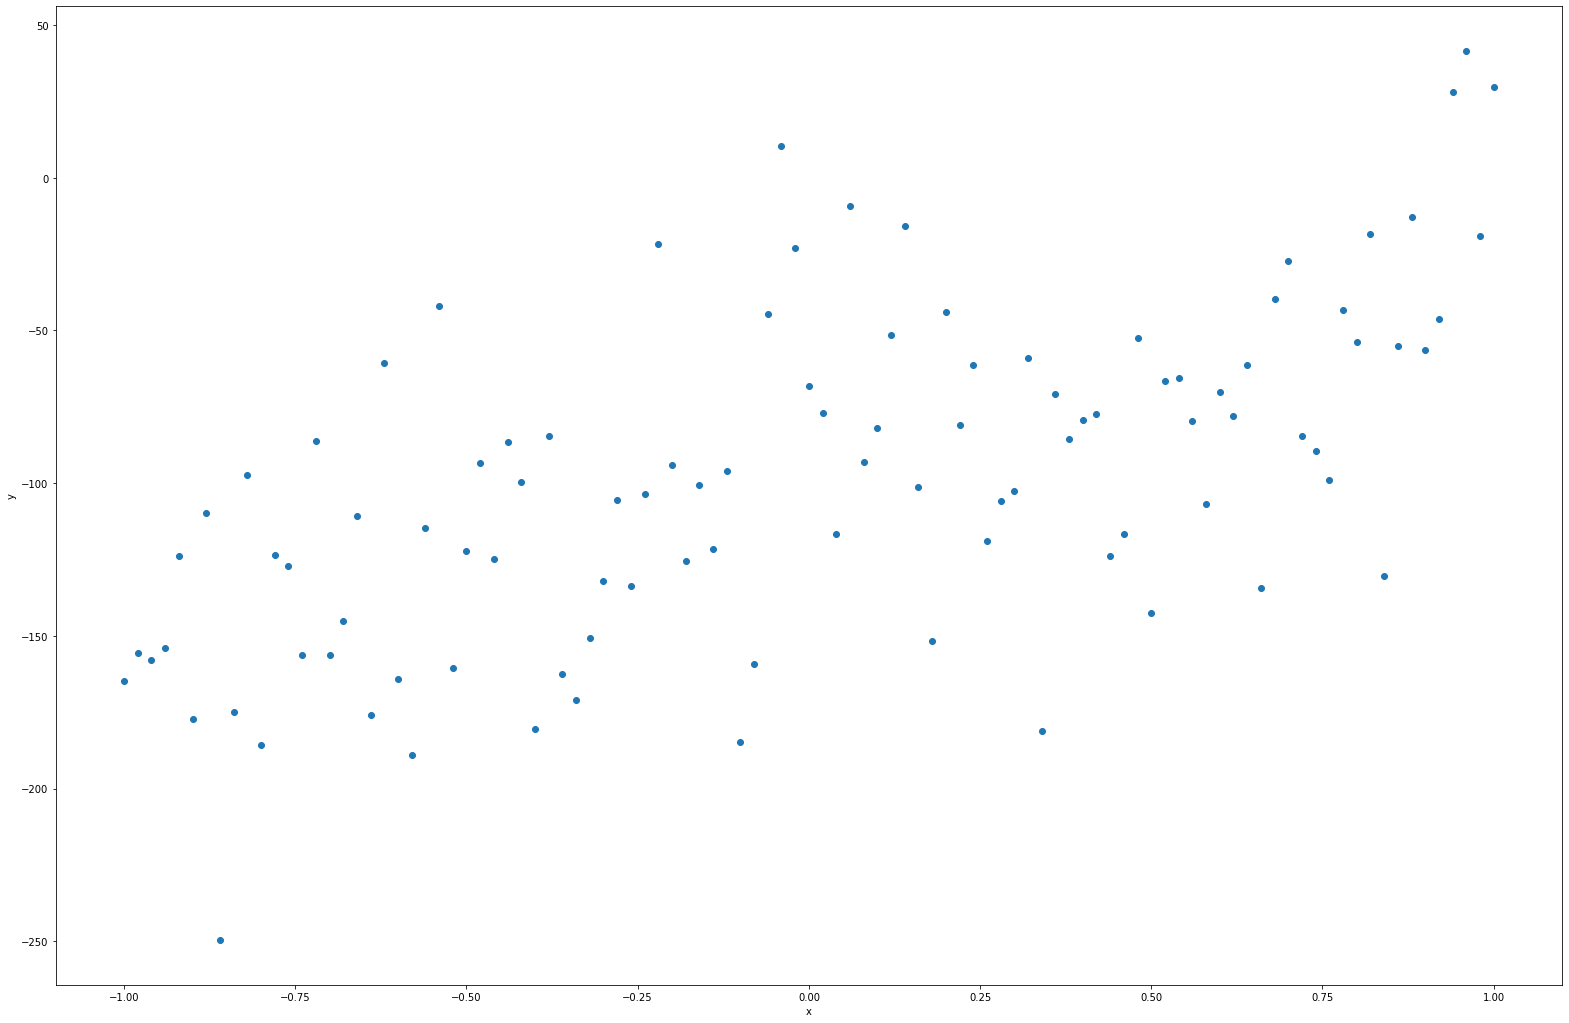

In [4]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(27,18));
ax = plt.axes();
ax.set_xlabel('x');
ax.set_ylabel('y');

plt.scatter(X_data, y_data);

Будемо реалізовувати просту лінійну регресійну модель: $f(x) = w_1 x + w_2$. Спочатку розіб'ємо набір на навчальний та тестовий, а також підготуємо його для навчання моделі.

In [100]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.23,
                                                    random_state = 42)

train_set = tf.data.Dataset.from_tensor_slices(
    (tf.cast(X_train, tf.float32),
     tf.cast(y_train, tf.float32))
)

## 2. Реалізація моделі

In [115]:
import os
import pickle 
import datetime

class SimpleReg():
    
    def __init__(self, epochs = 100, batch_size = 15, steps = None):
        # створюємо папку для збереження моделей
        if not os.path.exists("Saved Models 1"):
            os.makedirs("Saved Models 1")
            
        self.w1 = tf.Variable(0.0, name='w1')
        self.w2 = tf.Variable(0.0, name='w2')
        self.epochs = epochs 
        self.batch_size = batch_size
        
        if steps == None:
            self.steps_per_epoch = int(np.ceil(len(X_data) / batch_size))
        else:
            self.steps_per_epoch = steps
            
        self.models_dir = ""
        
        
    def loss(self, y_pred, y_true, alpha = 0.01):
        mse_batch = tf.reduce_mean(tf.square(y_true - y_pred))
        l2_reg    = tf.reduce_sum(tf.square(self.w1)) + tf.reduce_sum(tf.square(w2))
        return mse_batch + alpha * l2_reg
    
    def predict(self, X, numpy_ = False):
        if numpy_:
            result = self.w1 * X + self.w2
            return result.numpy() 
        
        return self.w1 * X + self.w2
    
    def set_w(self, w1, w2):
        self.w1 = w1
        self.w2 = w2
    
    def train(self, batched_data, lr = 1e-4, alpha = 0.01, print_ = True):
        train_X = tf.convert_to_tensor(X_train, dtype = tf.float32)
        train_y = tf.convert_to_tensor(y_train, dtype = tf.float32)
        
        # папка для збереження моделей
        current_time = datetime.datetime.now()
        current_time = current_time.strftime("%d-%m-%Y_%H-%M-%S")
        path = os.path.join("Saved Models 1", current_time)
        self.models_dir = path
        os.makedirs(path)
        
        step = 1
        for batch in batched_data:
            if step == self.epochs + 1:
                break
                
            X, y   = batch
            
            # градієнтний спуск
            for i in range(self.steps_per_epoch):
                with tf.GradientTape() as tape:
                    y_pred = self.predict(X)
                    current_loss = self.loss(y_pred, y, alpha)
                    
                gradient = tape.gradient(current_loss, [self.w1, self.w2])
                
                # змінюємо параметри
                self.w1.assign_sub(lr * gradient[0])
                self.w2.assign_sub(lr * gradient[1])
            
            if step % 10 == 0 and print_:
                epoch_loss = self.loss(self.predict(train_X), train_y).numpy()
                print(f"Епоха {step}, loss = {epoch_loss}")
                
            # зберігаємо параметри моделі через кожні 10 епох
            if step % 10 == 0 :
                saved_model = {"w1": self.w1.numpy(), "w2": self.w2.numpy()}
                model_path  = os.path.join(self.models_dir, str(step))
                file = open(model_path, "wb")
                pickle.dump(saved_model, file)
                file.close()
            
            step += 1
            
    def load_models(self):
        # метод для повернення моделей з останнього навчання
        models = {"epoch": [], "model": []}
        for file in os.listdir(self.models_dir):
            file_path = os.path.join(self.models_dir, file)
            
            with open(file_path, "rb") as f:
                model = pickle.load(f)
            
            models["epoch"].append(int(file))
            models["model"].append(model)
        
        return models
    

## 3. Навчання моделі

In [113]:
epochs = 100
batch_size = 77

tf.random.set_seed(42)
ds_train = train_set.shuffle(buffer_size=len(y_train))
ds_train = ds_train.repeat(count = None)
ds_train = ds_train.batch(batch_size)

model = SimpleReg(epochs = epochs, steps = 100)
model.train(ds_train)

Епоха 10, loss = 8996.8115234375
Епоха 20, loss = 6845.92529296875
Епоха 30, loss = 5379.92724609375
Епоха 40, loss = 4376.10986328125
Епоха 50, loss = 3684.81005859375
Епоха 60, loss = 3205.357421875
Епоха 70, loss = 2869.98095703125
Епоха 80, loss = 2632.98388671875
Епоха 90, loss = 2463.506103515625
Епоха 100, loss = 2340.660400390625


Погані результати функції втрат можна пояснити тим, що в датасеті дані дуже сильно розкидані, тому лінійна регресія не може підібрати параметри, які будуть добре описувати навчальну вибірку. Покажемо результат графічно

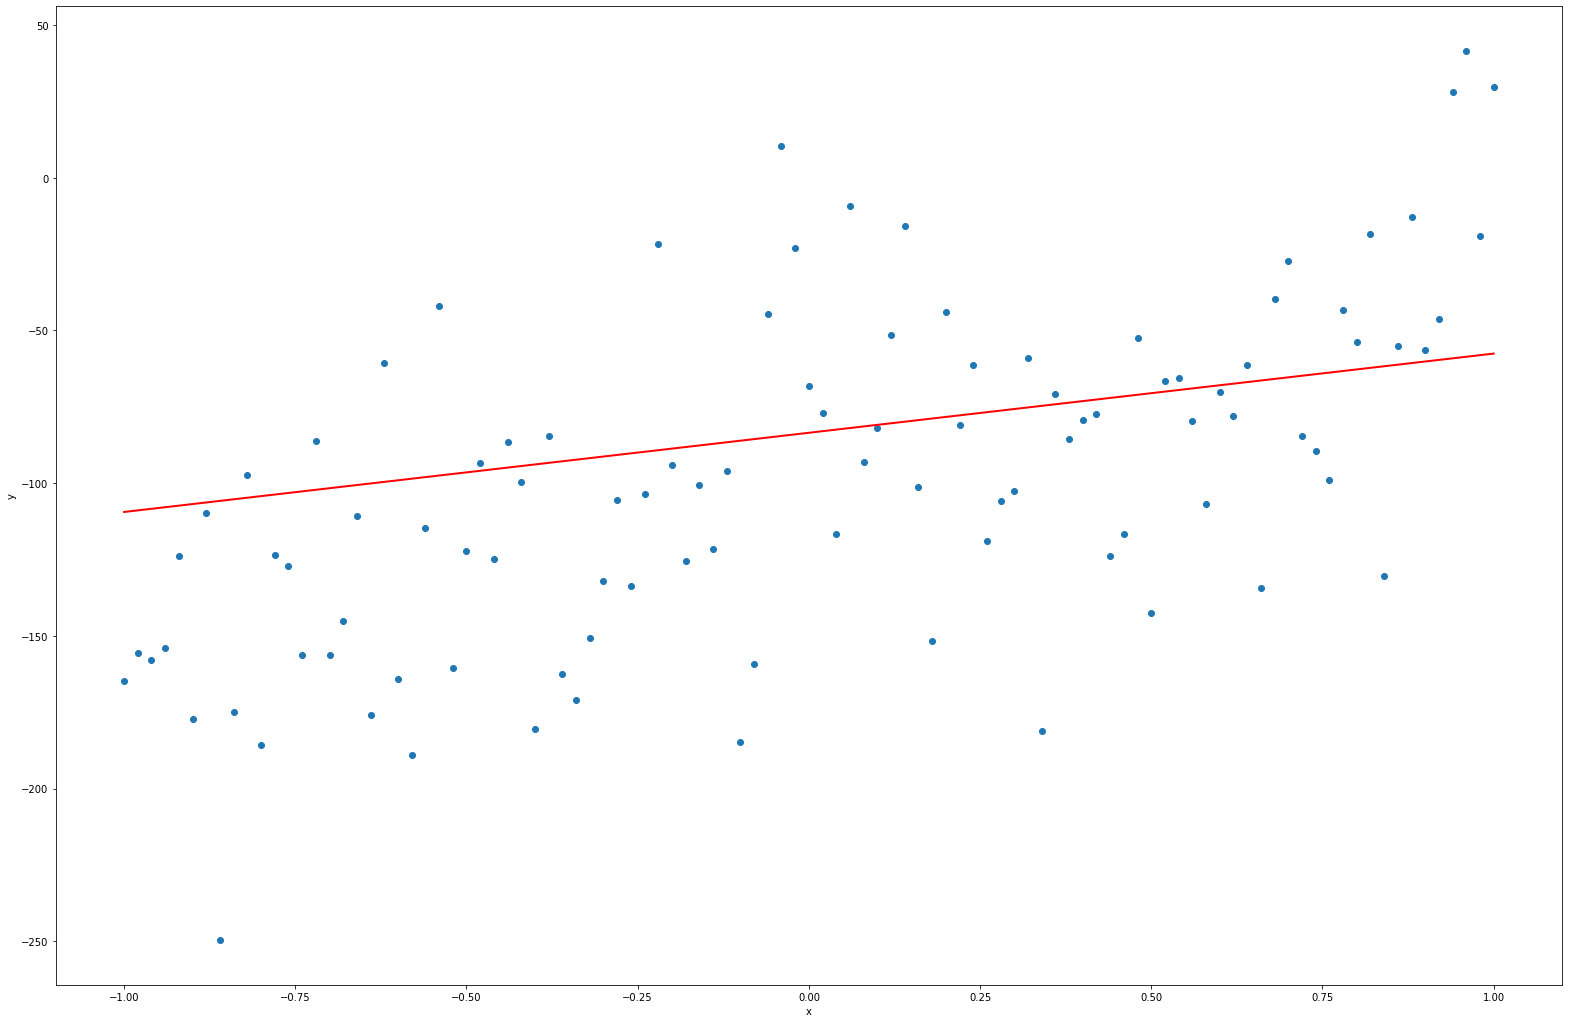

In [114]:
fig = plt.figure(figsize=(27,18));
ax = plt.axes();
ax.set_xlabel('x');
ax.set_ylabel('y');

plt.plot(X_data, model.predict(X_data, numpy_ = True), linewidth= 2, color = "r");
plt.scatter(X_data, y_data);
plt.show()

## 4. Підбір швидкості навчання та розміру міні-батчу

Візьмемо декілька значень, та подививмось яка модель краще описує дані. Для вибору моделі будемо використовувати метрику MSE.

In [120]:
from sklearn.metrics import mean_squared_error

info = {"learning_rate":[0.01, 0.05, 0.08, 0.02, 0.5, 0.08],
        "batch_size":   [25, 50, 40, 40, 30, 20]}

epochs = 150
steps_per_epoch = 100

for lr, b_size in zip(info["learning_rate"], info["batch_size"]):
    tf.random.set_seed(42)
    ds_train = train_set.shuffle(buffer_size=len(y_train))
    ds_train = ds_train.repeat(count = None)
    ds_train = ds_train.batch(b_size)
    
    model = SimpleReg(epochs = epochs, steps = steps_per_epoch)
    model.train(ds_train, lr = lr, print_ = False)
    prediction = model.predict(X_train)
    mse = mean_squared_error(prediction, y_train)
    print(f"learning rate = {lr}, batch size = {b_size}, mse = {mse}")

learning rate = 0.01, batch size = 25, mse = 1806.1104390475768
learning rate = 0.05, batch size = 50, mse = 1855.1250509362715
learning rate = 0.08, batch size = 40, mse = 1812.4006920002912
learning rate = 0.02, batch size = 40, mse = 1806.9188828290748
learning rate = 0.5, batch size = 30, mse = 1946.8121118702184
learning rate = 0.08, batch size = 20, mse = 2053.923607504711


накращі результати дала модель з гіперпараметрами: learning rate = 0.01, batch size = 25

## 5. Підбір парметра регуляризації

Для підбору цього гіперпараметра будемо використовувати тестову вибірку, щоб побачити яка модель менш "перенавчена"

In [127]:
epochs = 150
steps_per_epoch = 100
alphas = [1e-4, 1e-3, 1e-2, 0.1, 1]

for alpha in alphas:
    tf.random.set_seed(42)
    ds_train = train_set.shuffle(buffer_size=len(y_train))
    ds_train = ds_train.repeat(count = None)
    ds_train = ds_train.batch(25)
    
    model = SimpleReg(epochs = epochs, steps = steps_per_epoch)
    model.train(ds_train, lr = 0.01, alpha = alpha, print_ = False)
    prediction = model.predict(X_test)
    test_mse = mean_squared_error(prediction, y_test)
    print(f"alpha = {alpha} {' '*(6 - len(str(alpha)))} test mse = {test_mse}")

alpha = 0.0001  test mse = 1870.6275698520542
alpha = 0.001   test mse = 1871.5730080865796
alpha = 0.01    test mse = 1881.5595294556908
alpha = 0.1     test mse = 2009.3354943689494
alpha = 1       test mse = 2810.937527072079


найкращі результати дала модель з параметром регуляризації: 1e-4. Тепер покажемо графічно результат фінальної моделі:

In [128]:
tf.random.set_seed(42)
ds_train = train_set.shuffle(buffer_size=len(y_train))
ds_train = ds_train.repeat(count = None)
ds_train = ds_train.batch(25)

model = SimpleReg(epochs = 150, steps = 100)
model.train(ds_train, lr = 0.01, alpha = 1e-4)

Епоха 10, loss = 2097.825439453125
Епоха 20, loss = 1915.846923828125
Епоха 30, loss = 1976.946533203125
Епоха 40, loss = 1904.198974609375
Епоха 50, loss = 1937.355712890625
Епоха 60, loss = 1933.132568359375
Епоха 70, loss = 1948.9649658203125
Епоха 80, loss = 1916.9276123046875
Епоха 90, loss = 1921.24755859375
Епоха 100, loss = 1919.7410888671875
Епоха 110, loss = 1906.46337890625
Епоха 120, loss = 2037.7210693359375
Епоха 130, loss = 2023.6585693359375
Епоха 140, loss = 1972.1080322265625
Епоха 150, loss = 1909.861083984375


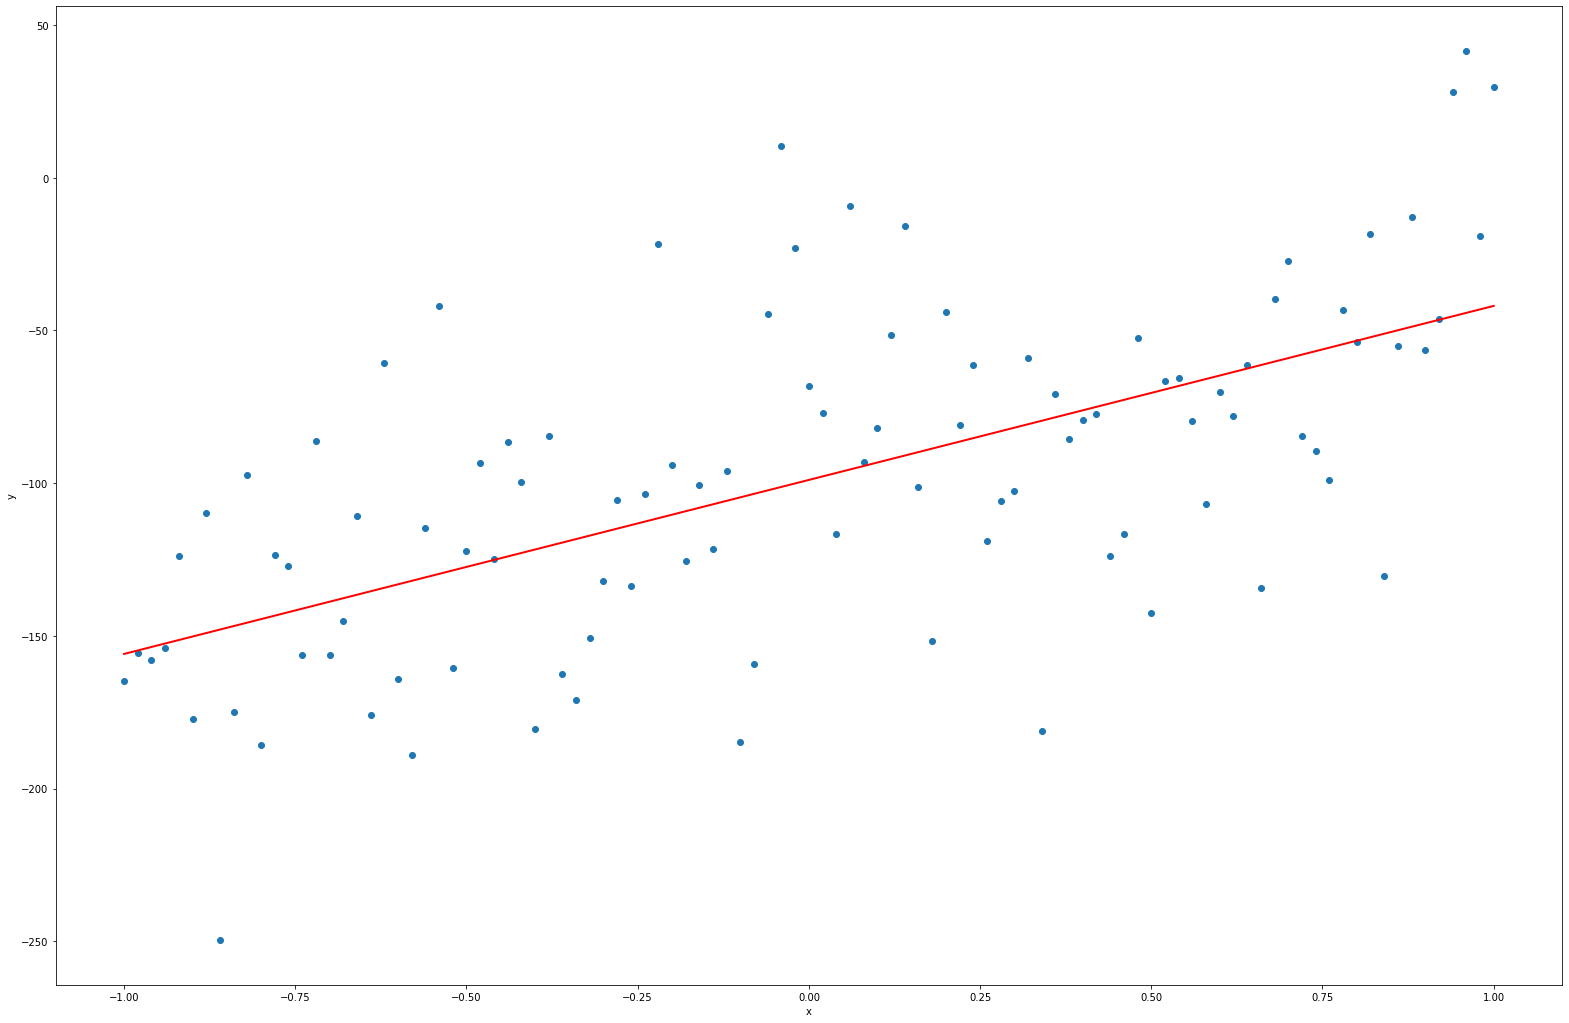

In [129]:
fig = plt.figure(figsize=(27,18));
ax = plt.axes();
ax.set_xlabel('x');
ax.set_ylabel('y');

plt.plot(X_data, model.predict(X_data, numpy_ = True), linewidth= 2, color = "r");
plt.scatter(X_data, y_data);
plt.show()

## 6. Перевірка функції для збереження моделей

Почнемо навчання та перервемо його, та подививмось чи коректно працює метод load_models

In [130]:
model = SimpleReg(epochs = 150, steps = 100)
model.train(ds_train, lr = 0.01, alpha = 1e-4)

Епоха 10, loss = 1931.376220703125
Епоха 20, loss = 1909.1636962890625
Епоха 30, loss = 1909.8326416015625
Епоха 40, loss = 1940.439208984375
Епоха 50, loss = 2023.0418701171875
Епоха 60, loss = 1912.0980224609375
Епоха 70, loss = 1915.861328125


KeyboardInterrupt: 

In [132]:
model.load_models()["model"]

[{'w1': 52.574265, 'w2': -91.77391},
 {'w1': 52.458443, 'w2': -99.5989},
 {'w1': 57.31307, 'w2': -98.67083},
 {'w1': 55.803368, 'w2': -91.162415},
 {'w1': 60.956158, 'w2': -87.18908},
 {'w1': 57.36858, 'w2': -95.1109},
 {'w1': 47.800407, 'w2': -95.629295}]

Як бачимо, метод працює коректно

# Друге завдання

https://www.kaggle.com/datasets/jainshukal/netflix-stock-price

In [48]:
import pandas as pd
import os
from IPython.display import display

path = os.path.join("Netflix Data", "NFLX.csv")
data = pd.read_csv(path)
display(data)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-12-16,119.800003,123.000000,118.089996,122.639999,122.639999,13181000
1,2015-12-17,123.970001,126.349998,122.419998,122.510002,122.510002,17284900
2,2015-12-18,120.849998,122.190002,117.919998,118.019997,118.019997,17948100
3,2015-12-21,119.510002,119.589996,115.660004,116.629997,116.629997,11670000
4,2015-12-22,117.300003,117.430000,114.860001,116.239998,116.239998,9689000
...,...,...,...,...,...,...,...
1002,2019-12-10,296.119995,298.940002,292.019989,293.119995,293.119995,10476100
1003,2019-12-11,294.489990,299.429993,294.200012,298.929993,298.929993,5589800
1004,2019-12-12,295.670013,299.170013,295.059998,298.440002,298.440002,4766600
1005,2019-12-13,298.500000,301.799988,297.250000,298.500000,298.500000,3879700


In [49]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1007.000000,1007.000000,1007.000000,1007.000000,1007.000000,1.007000e+03
mean,226.708094,229.972979,223.105690,226.670159,226.670159,9.730586e+06
std,103.305422,104.851349,101.458611,103.203785,103.203785,6.398967e+06
min,80.570000,84.699997,79.949997,82.790001,82.790001,1.616300e+06
25%,125.779999,127.165001,124.355000,125.514999,125.514999,5.573200e+06
50%,197.850006,199.440002,195.330002,198.000000,198.000000,7.857600e+06
75%,325.529999,330.835006,318.869995,325.220001,325.220001,1.178630e+07
max,421.380005,423.209991,413.079987,418.970001,418.970001,5.841040e+07


In [50]:
data_copy = data.copy()
data_copy = data_copy.rename(columns=str.lower)
data_copy['date'] = pd.to_datetime(data_copy['date'])

## 1. Візуалізація

In [51]:
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import pandas as pd


atr_names = list(data_copy.columns[1:])

fig = make_subplots(rows=6, cols=1, shared_xaxes=True, subplot_titles = (atr_names), vertical_spacing=0.02)
row = 1
for atr in data_copy.columns[1:]:
    fig.add_trace(go.Scatter(x=data_copy['date'], y=data_copy[atr], mode='lines',
                             name=str(atr), line=dict(width=2)), row = row, col = 1)
    row += 1

fig.update_layout(width=1000, height=3000, title = "Графіки часових рядів")
fig.show()

У графіку volume дуже багато аномальних значень, пов'язанних з  випадковими подіями, які передбачити неможливо. 

Перші 5 графиків дуже схожі між собою. Побудуємо матрицю кореляції.

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = data_copy.corr()
corr_matrix

,open,high,low,close,adj close,volume
open,1.000000,0.999489,0.999333,0.998712,0.998712,-0.095059
high,0.999489,1.000000,0.999264,0.999438,0.999438,-0.084998
low,0.999333,0.999264,1.000000,0.999448,0.999448,-0.107404
close,0.998712,0.999438,0.999448,1.000000,1.000000,-0.095180
adj close,0.998712,0.999438,0.999448,1.000000,1.000000,-0.095180
volume,-0.095059,-0.084998,-0.107404,-0.095180,-0.095180,1.000000


Коофіціент кореляції для перших 5 пунктів майже 1, тому можемо взяти будь який з них для прогнозування volume. Але спочатку приберемо аномалії за допомогою фільтра Хапеля. 

## 2.  Підготовка данних 

In [53]:
from hampel import hampel
1
outliers_indices = hampel(data_copy["volume"], window_size = 5, n = 3)
changed_volume = hampel(data_copy["volume"], window_size = 7, n = 3, imputation=True)
np_volume = data_copy["volume"].to_numpy()
data_copy["volume"] = changed_volume

Оновленний графік

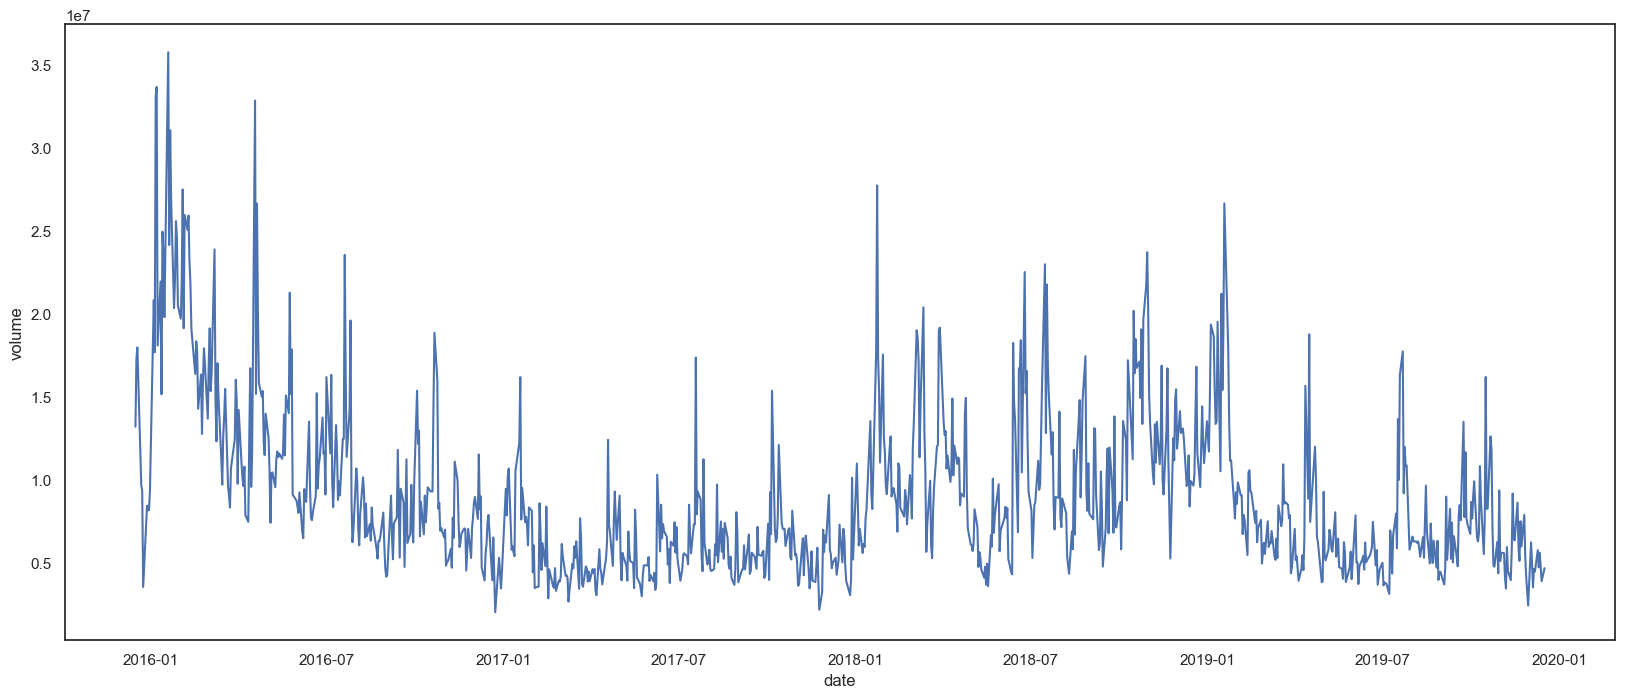

In [54]:
sns.set(rc = {'figure.figsize':(20,8)})
sns.set_style("white")

X = []
Y = []
for ind in outliers_indices:
    Y.append([np_volume[ind-1], np_volume[ind], np_volume[ind+1]])
    X.append([data_copy.date[ind-1], data_copy.date[ind], data_copy.date[ind+1]])



plot = sns.lineplot(x = data_copy.date, y = changed_volume)

In [55]:
data_copy = data_copy.set_index('date', drop=True)
data_copy

,open,high,low,close,adj close,volume
date,,,,,,
2015-12-16,119.800003,123.000000,118.089996,122.639999,122.639999,13181000
2015-12-17,123.970001,126.349998,122.419998,122.510002,122.510002,17284900
2015-12-18,120.849998,122.190002,117.919998,118.019997,118.019997,17948100
2015-12-21,119.510002,119.589996,115.660004,116.629997,116.629997,11670000
2015-12-22,117.300003,117.430000,114.860001,116.239998,116.239998,9689000
...,...,...,...,...,...,...
2019-12-10,296.119995,298.940002,292.019989,293.119995,293.119995,4712750
2019-12-11,294.489990,299.429993,294.200012,298.929993,298.929993,5589800
2019-12-12,295.670013,299.170013,295.059998,298.440002,298.440002,4766600


## 3 Реалізація моделі

Cтворюємо новий датафрейм де візьмемо компоненту open та volume

In [56]:


new_dict = {"pc": data_copy["open"].to_numpy(), "volume": data_copy["volume"].to_numpy()}
new_data = pd.DataFrame(new_dict)
new_data.index = data_copy.index 
new_data.describe()

,pc,volume
count,1007.000000,1.007000e+03
mean,226.708094,9.034839e+06
std,103.305422,4.980305e+06
min,80.570000,2.010400e+06
25%,125.779999,5.459600e+06
50%,197.850006,7.605200e+06
75%,325.529999,1.116440e+07
max,421.380005,3.572280e+07


In [57]:
import tensorflow as tf

def split_data(train_set, train_set_orig, lags = 3):
    
    train_data = []
    labels = []
    start = 0
    end = train_set.shape[0] - lags 
    for ind in range(start, end):
        train_data.append(train_set[ind:ind + lags])
        labels.append(train_set_orig[ind + lags])
        
    
    return train_data, labels

## 3.3 Створення моделі для прогнозування

Для прогнозування часового ряду буду навчати спрощену версію моделі VAR(Vector autoregression) для випадку двох змінних.

In [58]:
from sympy import *

def dict_maker(batch, X_variables, Y_variables):
    X, y = batch
    X = np.array(X)
    y = np.array(y)
    list_of_dicts = []
    
    for x_i, y_i in zip(X, y):
        dict_ = {}.copy()
        
        for x_var_value, x_var_name in zip(x_i[:,0], X_variables):
            dict_[x_var_name] = x_var_value 
        
        for y_var_value, y_var_name in zip(x_i[:,1], Y_variables):
            dict_[y_var_name] = y_var_value
            
        list_of_dicts.append(dict_)
    
    return list_of_dicts, y
        
def loss_2(list_of_dicts, labels, X_func, Y_func, W, lambda_):    

    loss_X = 0
    loss_Y = 0
    for dict_, y_i in zip(list_of_dicts, labels):
        loss_X += (y_i[0] - X_func.subs(dict_))**2
        loss_Y += (y_i[1] - Y_func.subs(dict_))**2
        
        loss_X = expand(loss_X)
        loss_Y = expand(loss_Y)
    

    
    loss_X = loss_X / len(list_of_dicts)
    loss_Y = loss_Y / len(list_of_dicts)
    
    reg_X = 0
    for var in W[0]:
        reg_X += var**2
    reg_X = expand(lambda_ * reg_X)
    loss_X += reg_X
    
    reg_Y = 0
    for var in W[1]:
        reg_Y += var**2
    reg_Y = expand(lambda_ * reg_Y)
    loss_Y += reg_Y
    
    
    return loss_X, loss_Y

In [59]:
class SimpleVAR():
    
    def __init__(self, lags):
        self.lags = lags
        
        # свторюємо матрицю W та словник з її значеннями:
        W         = [].copy()
        wx_values = {}.copy()
        wy_values = {}.copy()
        for row in range(1, 3):
            # заповнюємо матрицю змінними з бібліотеки sympy 
            var_names = ""
            for col in range(1, 2*self.lags + 1):
                var_name = "w_{" + f"{row}\,{col}" + "}"
                var_names = var_names + " " + var_name
                
                
            variables = symbols(var_names[1:])
            
            if row == 1:
                for var in variables:
                    wx_values[var] = 0.0
            else:
                for var in variables:
                    wy_values[var] = 0.0

            W.append(variables)
                
        
        # створюємо масив лагів
        lag_arr     = []
        X_variables = []
        Y_variables = []
        for i in range(self.lags, 0, -1):
            x_name = "X_{" + f"t-{i}" + "}"
            lag_arr.append([Symbol(x_name)])
            X_variables.append(Symbol(x_name))
            
        for i in range(self.lags, 0, -1):
            y_name = "Y_{" + f"t-{i}" + "}"
            lag_arr.append([Symbol(y_name)])
            Y_variables.append(Symbol(y_name))
        
        self.lag_arr     = np.array(lag_arr)
        self.W           = np.array(W)
        self.wx_values   = wx_values
        self.wy_values   = wy_values
        self.X_func      = np.matmul(self.W, self.lag_arr)[0][0] 
        self.Y_func      = np.matmul(self.W, self.lag_arr)[1][0]
        self.X_variables = X_variables
        self.Y_variables = Y_variables
            
        
    def train(self, batch_data, lr, steps_per_epoch, max_epochs = 100):
        
        step = 0
        for batch in batch_data:
            
            if step == max_epochs + 1:
                break
            
            list_of_dicts, labels = dict_maker(batch, self.X_variables, self.Y_variables)
            loss_X, loss_Y = loss_2(list_of_dicts, labels, a.X_func, a.Y_func, a.W, 0.01)
            
            # градієнтний спуск для loss_X
            variables = self.W[0]
            grad_X     = [diff(loss_X, var) for var in variables]
            grad_X_val = [float(f.subs(self.wx_values)) for f in grad_X]
            
            for i in range(steps_per_epoch):
                for index, var in enumerate(self.wx_values.keys()):
                    self.wx_values[var] = self.wx_values[var] - lr * grad_X_val[index]
                grad_X_val = [float(f.subs(self.wx_values)) for f in grad_X]
        
            
            # градієнтний спуск для loss_Y
            variables = self.W[1]
            grad_Y     = [diff(loss_Y, var) for var in variables]
            grad_Y_val = [float(f.subs(self.wy_values)) for f in grad_Y]
            
            for i in range(steps_per_epoch):
                for index, var in enumerate(self.wy_values.keys()):
                    self.wy_values[var] = self.wy_values[var] - lr * grad_Y_val[index]
                grad_Y_val = [float(f.subs(self.wy_values)) for f in grad_Y]
            
            
            print(f"epoch {step} loss = {loss_Y.subs(self.wy_values)}")

            step += 1
    
    def predict(self, last_obs, steps, train_std, train_mean):
        prediction = []
        X_func = self.X_func.subs(self.wx_values)
        Y_func = self.Y_func.subs(self.wy_values)
        train_std  = train_std.to_numpy()
        train_mean = train_mean.to_numpy()
        for i in range(steps):
            values = {}.copy()
        
            for x_i, x_label in zip(last_obs[:, 0], self.X_variables):
                values[x_label] = x_i
                
            for y_i, y_label in zip(last_obs[:, 1], self.Y_variables):
                values[y_label] = y_i
            
            x_pred = X_func.subs(values)
            y_pred = Y_func.subs(values)
            prediction.append([x_pred, y_pred])
            
            x_pred = (x_pred - train_mean[0]) / train_std[0]
            y_pred = (y_pred - train_mean[1]) / train_std[1]
            
            last_obs = last_obs[1:]
            last_obs = np.vstack((last_obs, np.array([[x_pred, y_pred]])))
            
        return np.array(prediction)

## 3.1 Навчання моделі

In [60]:
%%time
from IPython.display import display

BATCH_SIZE = 10
LAGS = 2

train_set = new_data[:900]
test_set  = new_data[900:]

TRAIN_MEAN = train_set.mean()
TRAIN_STD  = train_set.std()
train_set_orig = train_set.copy()
train_set  = (train_set - TRAIN_MEAN) / TRAIN_STD
train_set  = train_set


train_set, labels = split_data(train_set.to_numpy(), train_set_orig.to_numpy(), lags = LAGS)

train_data_batch = tf.data.Dataset.from_tensor_slices((train_set, labels))
train_data_batch = train_data_batch.batch(BATCH_SIZE).repeat()

a = SimpleVAR(LAGS)
a.train(train_data_batch, lr = 0.001, steps_per_epoch = 70, max_epochs = 20)
prediction = a.predict(train_set[-1], 107, train_std = TRAIN_STD, train_mean = TRAIN_MEAN)

epoch 0 loss = 88389188115289.2
epoch 1 loss = 100057072964011
epoch 2 loss = 13998012335649.3
epoch 3 loss = 14615590623533.5
epoch 4 loss = 9142855649118.60
epoch 5 loss = 21874916391055.5
epoch 6 loss = 15119699602970.1
epoch 7 loss = 15606150239751.0
epoch 8 loss = 68853980194992.4
epoch 9 loss = 4287725680699.63
epoch 10 loss = 6882721468128.39
epoch 11 loss = 7398249805705.96
epoch 12 loss = 9947831653538.41
epoch 13 loss = 11061647634961.3
epoch 14 loss = 21012640372862.8
epoch 15 loss = 17270540274987.7
epoch 16 loss = 1725744626658.10
epoch 17 loss = 3415015939922.23
epoch 18 loss = 6733172626038.87
epoch 19 loss = 10273252542325.2
epoch 20 loss = 3003045673927.99
CPU times: total: 26.4 s
Wall time: 26.5 s


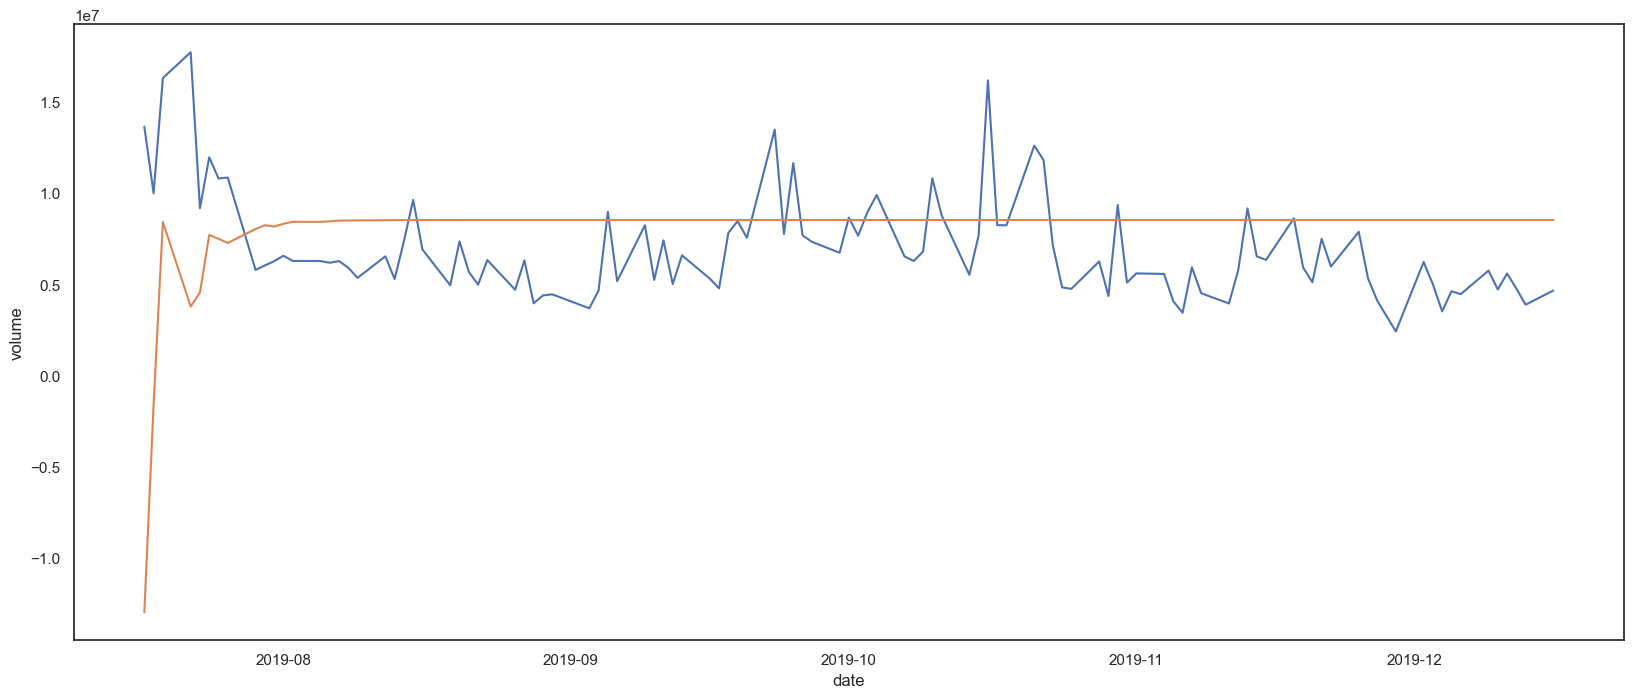

In [74]:
volume_pred = prediction[:, 1]
df = pd.DataFrame({"volume pred": volume_pred})
df.index = test_set.index

sns.set(rc = {'figure.figsize':(20,8)})
sns.set_style("white")

plot = sns.lineplot(x = df.index, y = test_set["volume"])
plot = sns.lineplot(x = df.index, y = df["volume pred"].astype(str).astype(float))



Збільшемо параметр Lags

In [75]:
%%time
from IPython.display import display

BATCH_SIZE = 10
LAGS = 5

train_set = new_data[:900]
test_set  = new_data[900:]

TRAIN_MEAN = train_set.mean()
TRAIN_STD  = train_set.std()
train_set_orig = train_set.copy()
train_set  = (train_set - TRAIN_MEAN) / TRAIN_STD
train_set  = train_set


train_set, labels = split_data(train_set.to_numpy(), train_set_orig.to_numpy(), lags = LAGS)

train_data_batch = tf.data.Dataset.from_tensor_slices((train_set, labels))
train_data_batch = train_data_batch.batch(BATCH_SIZE).repeat()

a = SimpleVAR(LAGS)
a.train(train_data_batch, lr = 0.001, steps_per_epoch = 70, max_epochs = 20)
prediction = a.predict(train_set[-1], 107, train_std = TRAIN_STD, train_mean = TRAIN_MEAN)

epoch 0 loss = 86568581964863.6
epoch 1 loss = 37218857616002.2
epoch 2 loss = 14116466141071.9
epoch 3 loss = 6033101639864.85
epoch 4 loss = 10523650067401.0
epoch 5 loss = 8109358965234.23
epoch 6 loss = 7370831341768.59
epoch 7 loss = 50886979739894.4
epoch 8 loss = 11887152267047.1
epoch 9 loss = 2306744449129.10
epoch 10 loss = 13180219444598.3
epoch 11 loss = 3990177432244.40
epoch 12 loss = 5537637982320.45
epoch 13 loss = 9387503937704.11
epoch 14 loss = 27349479114617.2
epoch 15 loss = 4453332348909.41
epoch 16 loss = 1076934502362.77
epoch 17 loss = 3159513705242.52
epoch 18 loss = 6592471000173.40
epoch 19 loss = 8345679886385.17
epoch 20 loss = 10663640336014.8
CPU times: total: 4min 27s
Wall time: 4min 28s


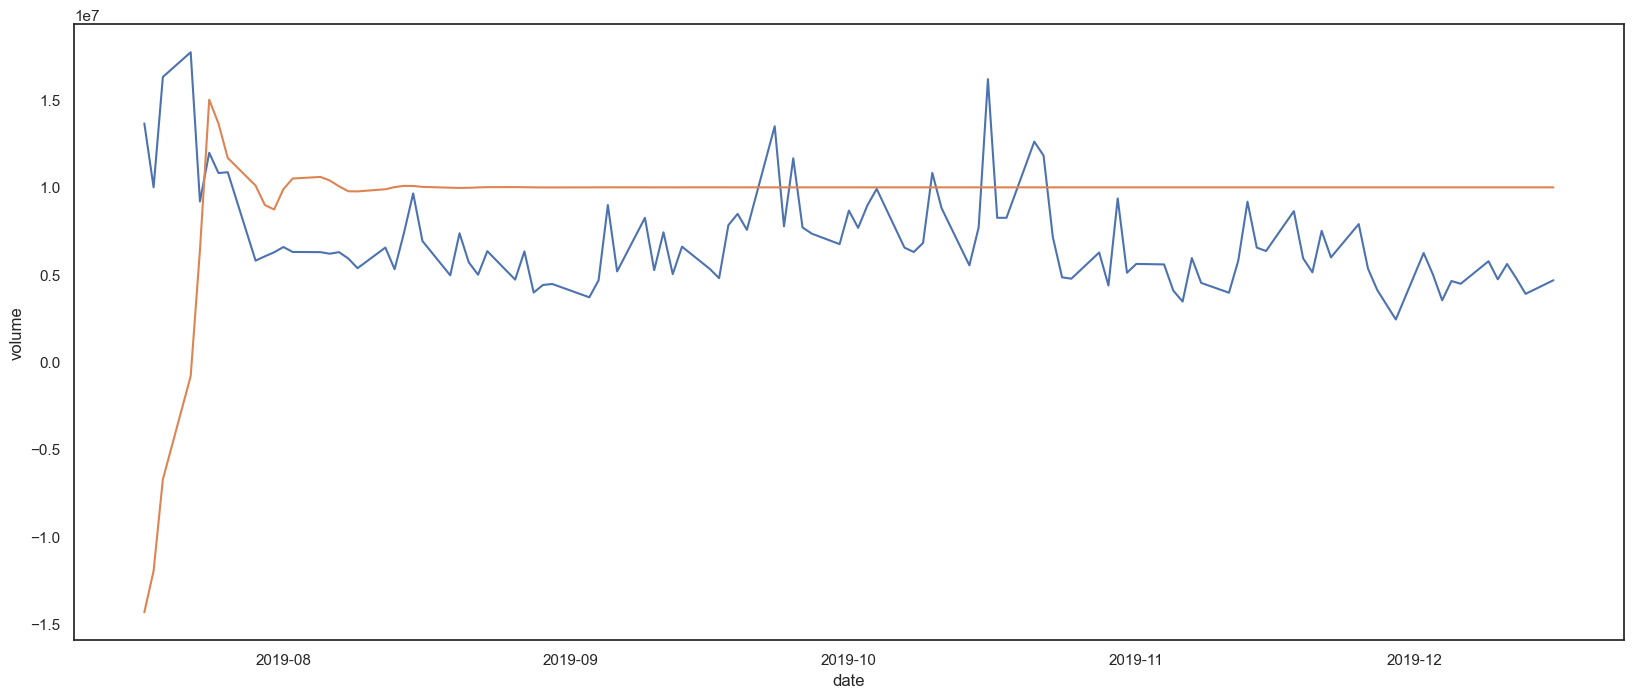

In [76]:
volume_pred = prediction[:, 1]
df = pd.DataFrame({"volume pred": volume_pred})
df.index = test_set.index

sns.set(rc = {'figure.figsize':(20,8)})
sns.set_style("white")

plot = sns.lineplot(x = df.index, y = test_set["volume"])
plot = sns.lineplot(x = df.index, y = df["volume pred"].astype(str).astype(float))


Отримали погані результати. Скоріше за все такі важкі процесси неможливо описати за допомогою моделі авторегресії. Бо має природу яка залежить від великої кількості випадкових подій, які неможливо описати чи спрогнозувати. 


# Висновок

У ході опрацювання першого датасету була проведена його візуалізація та підібрана регресійна модель, а саме лінійна регресія. Після цього був створений клас PolyModel, який реалізує дану модель. Були підібрані кращі параметри для цієї моделі

У ході опрацювання другого датасету була проведена його візуалізація та аналіз, у ході якого було виявлено, що перші 5 атрибутів з датасету дуже сильно корелюють між собою, а також те, що в атрибуті volume є аномально великі значення, які залежать від випадкових подій. Була реалізована модель векторної авторегресії(VAR) для двох парметрів, яка мала передбачати атрибут volume за допомогою його значень та значень. Данна модель дала дуже велику помилку узагальнення, а також досить довго навчалась, тому було вирішено створити більш просту модель, яка буде використовувати дані тільки одного атрибуту для його передбачення, а саме авторегресійну модель(AR). Були підібрані найкращі параметри для цієї моделі. Данна модель хоч і дала меншу помилку узагальнення, але всеодно дала погані результати, скоріш за все це через те що дані мають складну природу, тому для їх передбачення потрібно використовувати більш потужніші моделі, наприклад LSTM чи градієнтний бустинг.